**Ziyi Zhang 1005282720**

# Homework 6: Part I

1. Go get data from kaggle.com and do a ***(Univariate) Bayesian Logistic Regression*** analysis

2. Adjust the code below to specify that the outcomes have a Bernoulli distribution and use a ***logit*** or ***probit link function*** (or $\Pr(z\leq 0)$ for latent $z$ ) to correctly paramterize the predicted values of the observed outcomes 

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

3. Choose ***prior*** that are sensible for your specification 

4. [Optional] Assess the performance of the MCMC and any issues or warnings in the [standard manner](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Go get data from kaggle.com and do a ***Multivariate Bayesian Logistic Regression*** analysis

**Solution:**

The dataset I will be using is called Medical Cost Personal Datasets, and can be accessed using this link: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az

In [2]:
# Load data
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's say that we want to predict 'smoker' from 'bmi'

In [3]:
# Convert 'smoker' to binary and standarize 'bmi'
data['smoker'] = data['smoker'].map({'yes':1, 'no':0})
data['bmi_std'] = (data['bmi'] - data['bmi'].mean()) / data['bmi'].std()
data.head()

,age,sex,bmi,children,smoker,region,charges,bmi_std
0,19,female,27.900,0,1,southwest,16884.92400,-0.453151
1,18,male,33.770,1,0,southeast,1725.55230,0.509431
2,28,male,33.000,3,0,southeast,4449.46200,0.383164
3,33,male,22.705,0,0,northwest,21984.47061,-1.305043
4,32,male,28.880,0,0,northwest,3866.85520,-0.292447


In [4]:
n, p = data.shape[0], 1
X = data['bmi_std'].values[:, None] # making sure X is 2D array
y = data['smoker'].values

with pm.Model() as MLR:
    
    # Priors
    beta = pm.Normal('beta', mu = 0, sigma = 10, shape = (p,))
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)
    
    # Calculating the probability p(y=1)
    p = pm.Deterministic('p', pm.math.sigmoid(alpha + pm.math.dot(X, beta)))
    
    # Likelihood
    y = pm.Bernoulli('y', p=p, observed=y)
    
with MLR:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

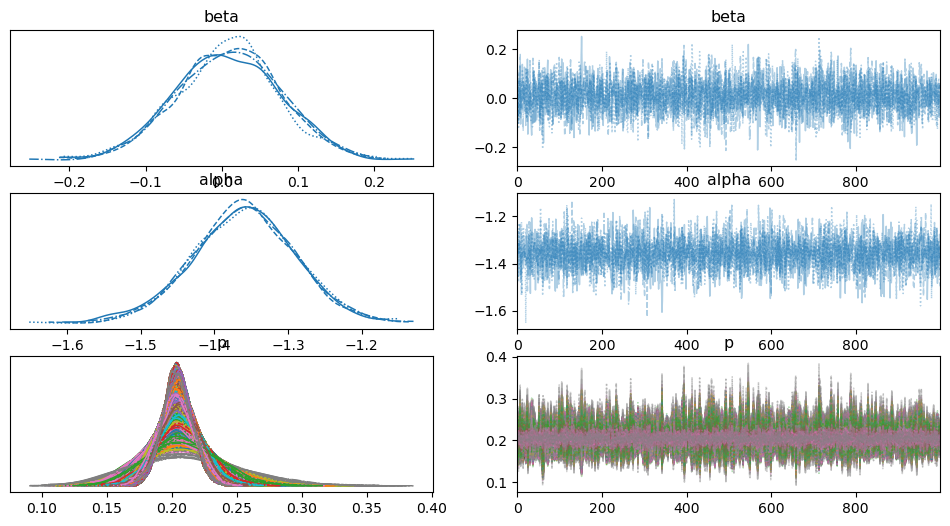

In [5]:
# Trace plots
az.plot_trace(idata)

# Homework 6: Part II<br>Regularized Loss Functions

***Machine Learning*** fits models by optimizing penalized ***loss functions***

Two classic regularizations are "ridge" and "lasso" regression, which respectively use $L_2$ and $L_1$ penalty functions

- Ridge: $$\sum_{i=1}^n \frac{1}{2}(y_i-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_2^2 $$
- Lasso: $$\sum_{i=1}^n \frac{1}{2}(y-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_1$$
    
Show that for $\sigma=1$ and ***hyperparameters*** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either ***normal*** or ***Laplace*** prior distributions have analagous forms to the above expressions

Now write down and understand the following: "Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distributions are nonetheless 'regularizations' of the likelihood through the prior."

**Solution:**

To show that $\sigma = 1$ and hyperparameters $\beta_{j} = 0$ (ignoring normalizng proportionality constants), the log posterior distributions for $\beta$ using either normal or Laplace prior distributions have analogous forms to the above expressions of Lasso and Ridge regressions.

For the Ridge Regression, the loss function includes a penalty term $\lambda \sum_{j=1}^n \beta_j^2$. In bayesian terms, this corresponds to assuming a normal prior for each $\beta_{j}$ with mean 0 and variance $\frac{1}{\lambda}$. The log posterior is then (up to a proportionality constant):

$\log p(\beta | X, y) \propto - \frac{1}{2\sigma^{2}} ||y - X\beta||_2^2 - \frac{\lambda}{2}||\beta||_2^2$

For the lasso regression, the loss function includes a penalty term $\lambda \sum_{j=1}^n |\beta_j|$. This corresponds to a Laplace prior for $\beta_{j}$ with a scale parameter $\frac{1}{\lambda}$. The log posterior looks like:

$\log p(\beta | X, y) \propto - \frac{1}{2\sigma^{2}} ||y - X\beta||_2^2 - \lambda||\beta||_1$

To rewrite these as log posterior distributions, we recognize that the likelihood part of the posterior is proportional to $e^{- \frac{1}{2 \sigma^2} ||y - X\beta||_2^2}$, while the prior for Ridge is proportional to $e^{- \frac{\sigma}{2} ||\beta||_2^2}$ and for Lasso it's proportional to $e^{- \lambda ||\beta||_1}$.

Therefore, if we choose $\lambda = 1$ and $\sigma = 1$, then the log posterior distribution for Ridge regression in Bayesian terms (assuming a normal prior) becomes:

$\log p(\beta | X, y) \propto - \frac{1}{2} ||y - X\beta||_2^2 - \frac{1}{2}||\beta||_2^2$

And the posterior distribution for Lasso regression (assuming a Laplace prior becomes):

$\log p(\beta | X, y) \propto - \frac{1}{2} ||y - X\beta||_2^2 - ||\beta||_1$

These expressions are the Bayesian counterparts to the penalized loss functions of Ridge and Lasso regression, showing that regularized regression can be interpreted as a Bayesian inference problem with specific prior distirbutions on the regression coefficients.

"Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distributions are nontheless 'regularizations' of the likelihood through the prior."

This quote emphasizes that while Bayesians are not explicitly performing optimization to find point estimates as frequentist penalized regression does, the effect of the priors in a Bayesian model is to introduce a form of regularization, influencing the model towards certain values of $\beta$ based on the prior beliefs. 